### Problem description:
This is an oceanographic regression task using the NDCB (National Data Buoy Center) data. The goal is to predict significant wave height using various supervised machine learning models. Accurate prediction of wave height is critical for marine forecasting, offshore operations, and coastal hazard mitigation. Multiple algorithms are compared to better asses their performance. 

github: https://github.com/PanakIllustrations/4622-Project-1


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [74]:
def dl_ndbc_data(station_id, year):
    """
    station_id (str): NDBC station ID
    year (str): Year to download
    Returns pandas.DataFrame
    """
    url = f"https://www.ndbc.noaa.gov/view_text_file.php?filename={station_id}h{year}.txt.gz&dir=data/historical/stdmet/"
    
    print(f"Downloading data from station id: {station_id}, year: {year}")
    print(f"URL: {url}")
    
    try:
        response = requests.get(url, timeout=30)
        if response.status_code == 200:
            lines = response.text.strip().split('\n')
            if len(lines) > 2:
                headers = lines[0].split()
                units = lines[1].split()
                
                # Parse data
                data_lines = []
                for line in lines[2:]:
                    if line.strip():
                        data_lines.append(line.split())
                
                df = pd.DataFrame(data_lines, columns=headers)
                
                # Convert to numeric
                for col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                
                return df, units, headers
        return None, None, None
    except Exception as e:
        print(f"Download failed: {e}")
        return None, None, None

### Data Description

- **Source**: National Data Buoy Center (NDBC), NOAA  
  [https://www.ndbc.noaa.gov/](https://www.ndbc.noaa.gov/)
- **Data Type**: Tabular, time-series weather/ocean data
- **Samples**: ~50,000 rows
- **Features**: 
  - ~15 total (e.g., wind speed, wave period, air/water temperature, barometric pressure)
  - Data types: Mixed (numerical, time)
  - Target variable: `WVHT` – significant wave height (in meters)


In [60]:
year = "2024"
station_id = "44013"  # Boston

df, units, headers = dl_ndbc_data(station_id, year)

variable_info = {
    'WDIR': ('Wind Direction', 'degrees', 'Wind direction (0-360°)'),
    'WSPD': ('Wind Speed', 'm/s', 'Primary predictor - wind velocity'),
    'WVHT': ('Significant Wave Height', 'm', 'Target variable - height of waves'),
    'PRES': ('Atmospheric Pressure', 'hPa', 'Air pressure at sea level'),
    'ATMP': ('Air Temperature', '°C', 'Temperature of air'),
    'WTMP': ('Water Temperature', '°C', 'Sea surface temperature')
}

print("Dataset Variables:")
for i, col in enumerate(df.columns):
    if col in variable_info:
        name, unit, description = variable_info[col]
        print(f"  {i+1}. {col}: {name} ({unit}) - {description}")
    else:
        print(f"  {i+1}. {col}: {col}")

URL: https://www.ndbc.noaa.gov/view_text_file.php?filename=44013h2024.txt.gz&dir=data/historical/stdmet/
Dataset Variables:
  1. #YY: #YY
  2. MM: MM
  3. DD: DD
  4. hh: hh
  5. mm: mm
  6. WDIR: Wind Direction (degrees) - Wind direction (0-360°)
  7. WSPD: Wind Speed (m/s) - Primary predictor - wind velocity
  8. GST: GST
  9. WVHT: Significant Wave Height (m) - Target variable - height of waves
  10. DPD: DPD
  11. APD: APD
  12. MWD: MWD
  13. PRES: Atmospheric Pressure (hPa) - Air pressure at sea level
  14. ATMP: Air Temperature (°C) - Temperature of air
  15. WTMP: Water Temperature (°C) - Sea surface temperature
  16. DEWP: DEWP
  17. VIS: VIS
  18. TIDE: TIDE


In [61]:
print("Data types:")
print(df.dtypes)

# Handle NDBC missing value codes
print(f"\nOriginal shape: {df.shape}")

# NDBC codes for missing data
missing_codes = [99.00, 999.0, 9999.0, 99, 999, 9999]
df_clean = df.copy()

for code in missing_codes:
    df_clean = df_clean.replace(code, np.nan)

# Check missing values
print("\nMissing values after cleaning NDBC codes:")
missing_summary = pd.DataFrame({
    'Missing_Count': df_clean.isnull().sum(),
    'Missing_Percentage': (df_clean.isnull().sum() / len(df_clean) * 100).round(2)
})
print(missing_summary)

# Remove rows with missing target variable
if 'WVHT' in df_clean.columns:
    initial_rows = len(df_clean)
    df_clean = df_clean.dropna(subset=['WVHT'])
    removed_rows = initial_rows - len(df_clean)
    print(f"\nRemoved {removed_rows} rows with missing wave height data")

print(f"Final cleaned shape: {df_clean.shape}")


Data types:
#YY       int64
MM        int64
DD        int64
hh        int64
mm        int64
WDIR      int64
WSPD    float64
GST     float64
WVHT    float64
DPD     float64
APD     float64
MWD       int64
PRES    float64
ATMP    float64
WTMP    float64
DEWP    float64
VIS     float64
TIDE    float64
dtype: object

Original shape: (52665, 18)

Missing values after cleaning NDBC codes:
      Missing_Count  Missing_Percentage
#YY               0                0.00
MM                0                0.00
DD                0                0.00
hh                0                0.00
mm                0                0.00
WDIR            115                0.22
WSPD             25                0.05
GST              25                0.05
WVHT          35241               66.92
DPD           35557               67.52
APD           35241               66.92
MWD           35838               68.05
PRES             43                0.08
ATMP             33                0.06
WTMP          

In [62]:
print("Descriptive statistics:")
print(df_clean.describe().round(3))

# Check for unrealistic values (outliers)
print("\nData range validation:")
if 'WVHT' in df_clean.columns:
    wvht_range = f"Wave height: {df_clean['WVHT'].min():.2f} to {df_clean['WVHT'].max():.2f} m"
    print(f"  {wvht_range}")
    
if 'WSPD' in df_clean.columns:
    wspd_range = f"Wind speed: {df_clean['WSPD'].min():.2f} to {df_clean['WSPD'].max():.2f} m/s"
    print(f"  {wspd_range}")

if 'PRES' in df_clean.columns:
    pres_range = f"Pressure: {df_clean['PRES'].min():.2f} to {df_clean['PRES'].max():.2f} hPa"
    print(f"  {pres_range}")

Descriptive statistics:
           #YY         MM         DD         hh         mm       WDIR  \
count  17424.0  17424.000  17424.000  17424.000  17424.000  17387.000   
mean    2024.0      6.499     15.745     11.505     25.017    192.528   
std        0.0      3.450      8.815      6.920     15.000     98.237   
min     2024.0      1.000      1.000      0.000     10.000      1.000   
25%     2024.0      3.000      8.000      6.000     10.000    123.000   
50%     2024.0      7.000     16.000     12.000     40.000    198.000   
75%     2024.0      9.000     23.000     17.000     40.000    276.000   
max     2024.0     12.000     31.000     23.000     40.000    360.000   

            WSPD        GST       WVHT        DPD        APD        MWD  \
count  17422.000  17422.000  17424.000  17108.000  17424.000  16827.000   
mean       5.517      7.035      0.926      7.459      4.575    122.651   
std        2.987      3.817      0.709      2.962      1.241     78.063   
min        0.000  

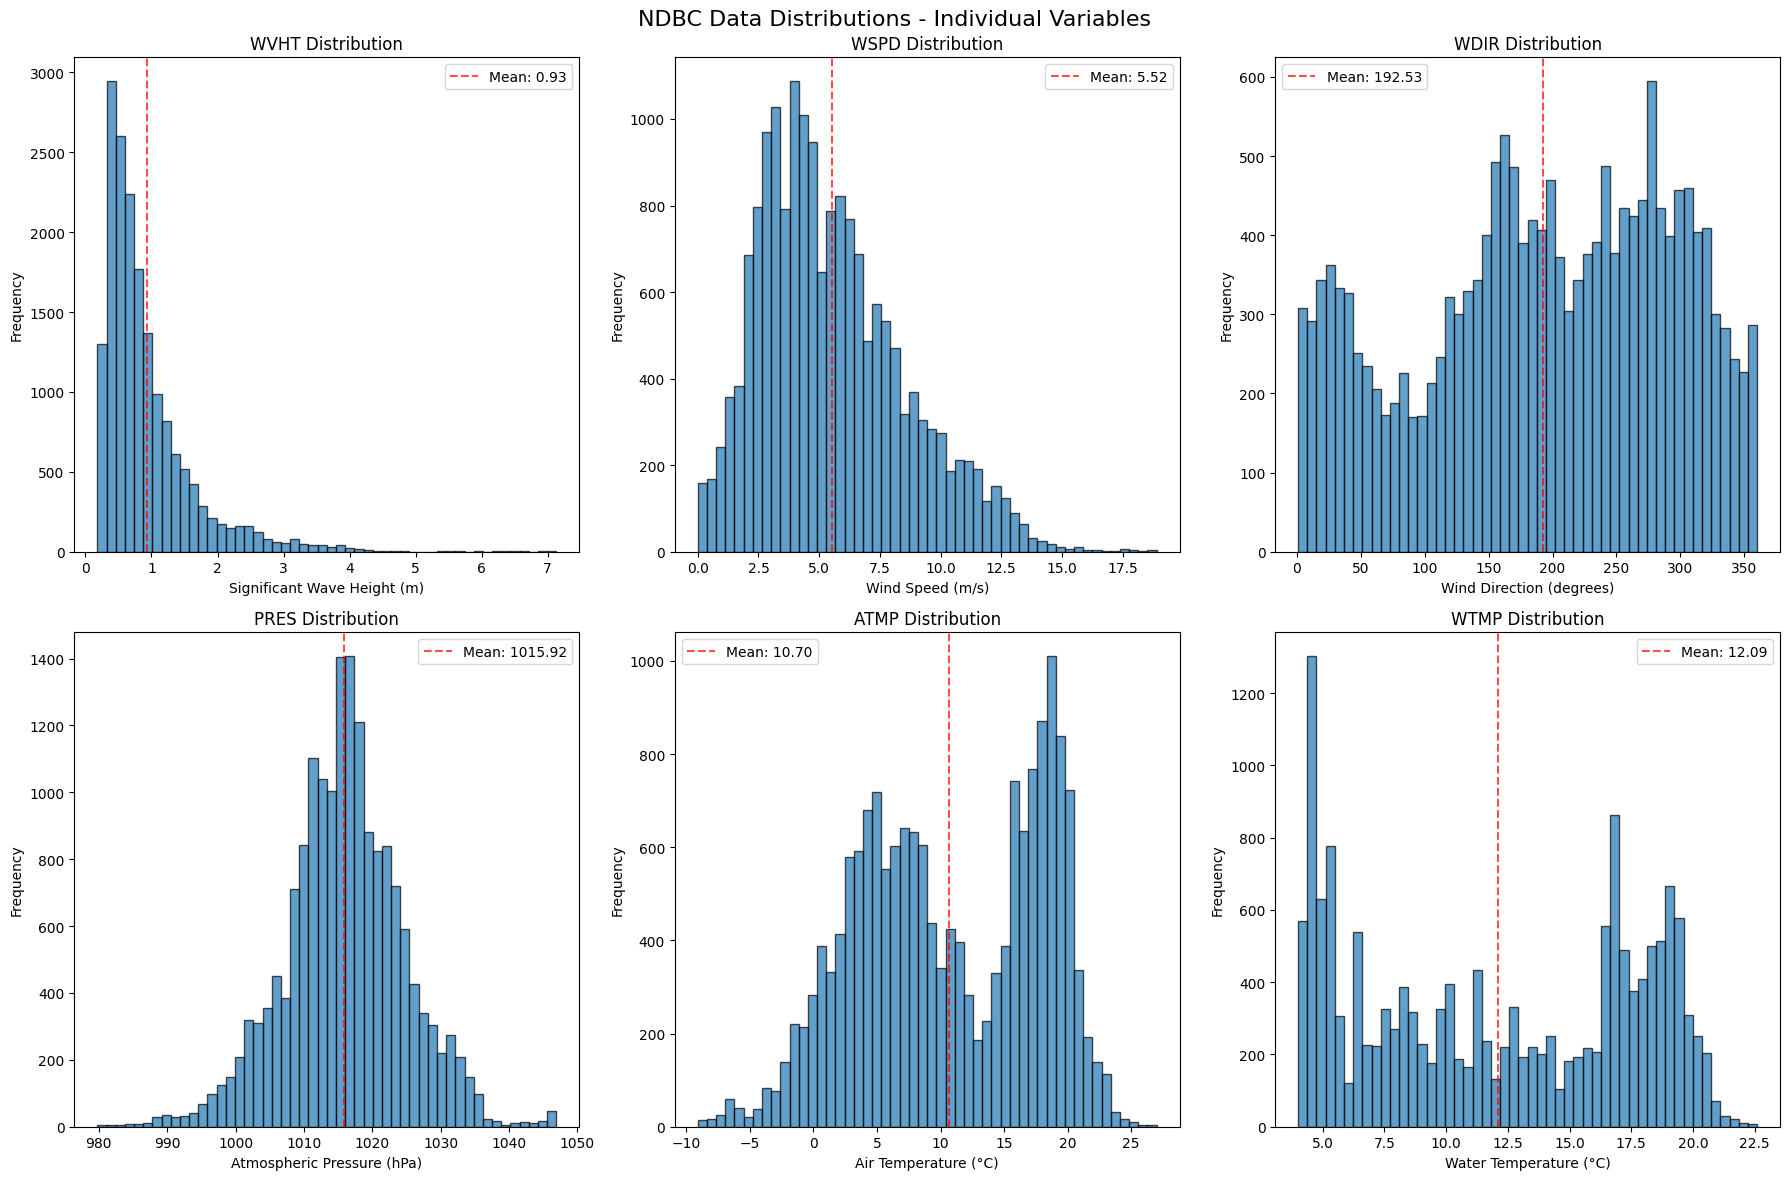

Distribution characteristics:
  WVHT: Skewness = 2.432, Kurtosis = 8.915
  WSPD: Skewness = 0.718, Kurtosis = 0.196
  WDIR: Skewness = -0.268, Kurtosis = -0.982
  PRES: Skewness = -0.061, Kurtosis = 0.745
  ATMP: Skewness = -0.167, Kurtosis = -1.084
  WTMP: Skewness = -0.021, Kurtosis = -1.500


In [63]:
available_vars = [col for col in ['WVHT', 'WSPD', 'WDIR', 'PRES', 'ATMP', 'WTMP'] if col in df_clean.columns]

if len(available_vars) >= 4:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('NDBC Data Distributions - Individual Variables', fontsize=16)
    
    for i, var in enumerate(available_vars[:6]):
        row = i // 3
        col = i % 3
        
        # Histogram
        axes[row, col].hist(df_clean[var].dropna(), bins=50, alpha=0.7, edgecolor='black')
        axes[row, col].set_title(f'{var} Distribution')
        if var in variable_info:
            axes[row, col].set_xlabel(f'{variable_info[var][0]} ({variable_info[var][1]})')
        else:
            axes[row, col].set_xlabel(var)
        axes[row, col].set_ylabel('Frequency')
        
        # Add statistics text
        mean_val = df_clean[var].mean()
        std_val = df_clean[var].std()
        axes[row, col].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
        axes[row, col].legend()
    
    # Remove empty subplots
    for i in range(len(available_vars), 6):
        row = i // 3
        col = i % 3
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

print("Distribution characteristics:")
for var in available_vars:
    data = df_clean[var].dropna()
    skewness = data.skew()
    kurtosis = data.kurtosis()
    print(f"  {var}: Skewness = {skewness:.3f}, Kurtosis = {kurtosis:.3f}")

Correlation matrix:
       WVHT   WSPD   WDIR   PRES   ATMP   WTMP
WVHT  1.000  0.618 -0.142 -0.214 -0.397 -0.392
WSPD  0.618  1.000  0.103 -0.259 -0.423 -0.375
WDIR -0.142  0.103  1.000 -0.127 -0.169 -0.104
PRES -0.214 -0.259 -0.127  1.000 -0.085  0.030
ATMP -0.397 -0.423 -0.169 -0.085  1.000  0.916
WTMP -0.392 -0.375 -0.104  0.030  0.916  1.000


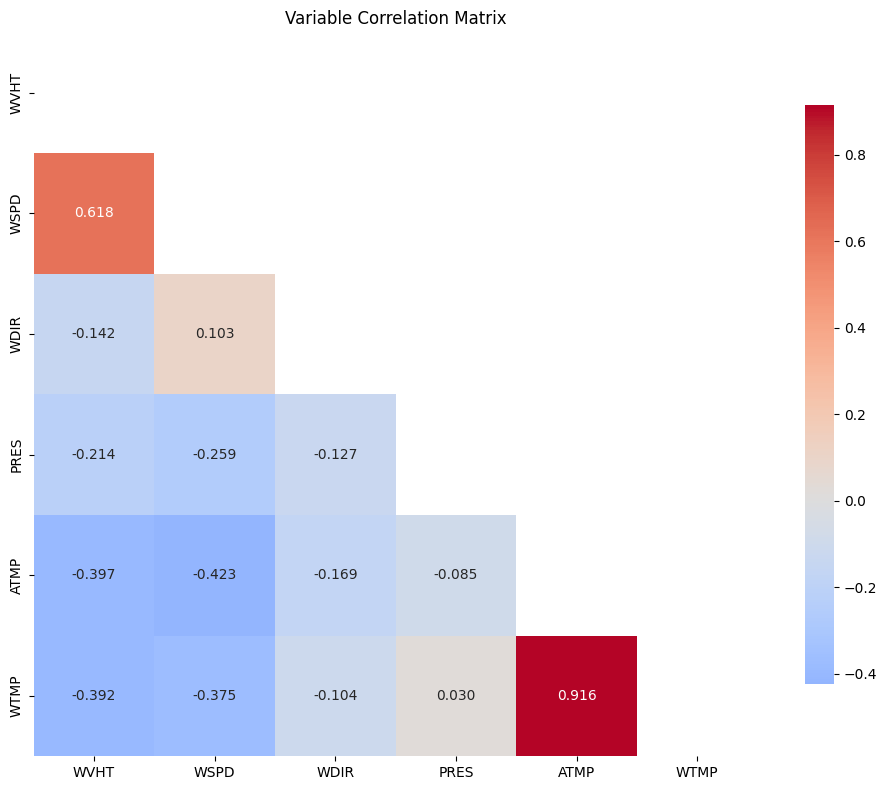


Correlations with Wave Height (WVHT):
  WSPD: 0.618 (Moderate positive correlation)
  ATMP: -0.397 (Moderate negative correlation)
  WTMP: -0.392 (Moderate negative correlation)
  PRES: -0.214 (Weak negative correlation)
  WDIR: -0.142 (Weak negative correlation)


In [64]:
correlation_matrix = df_clean[available_vars].corr()

print("Correlation matrix:")
print(correlation_matrix.round(3))

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Variable Correlation Matrix')
plt.tight_layout()
plt.show()

# Analyze correlations with target variable
if 'WVHT' in available_vars:
    print("\nCorrelations with Wave Height (WVHT):")
    target_corr = correlation_matrix['WVHT'].sort_values(key=abs, ascending=False)
    for var, corr in target_corr.items():
        if var != 'WVHT':
            strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.3 else "Weak"
            direction = "positive" if corr > 0 else "negative"
            print(f"  {var}: {corr:.3f} ({strength} {direction} correlation)")

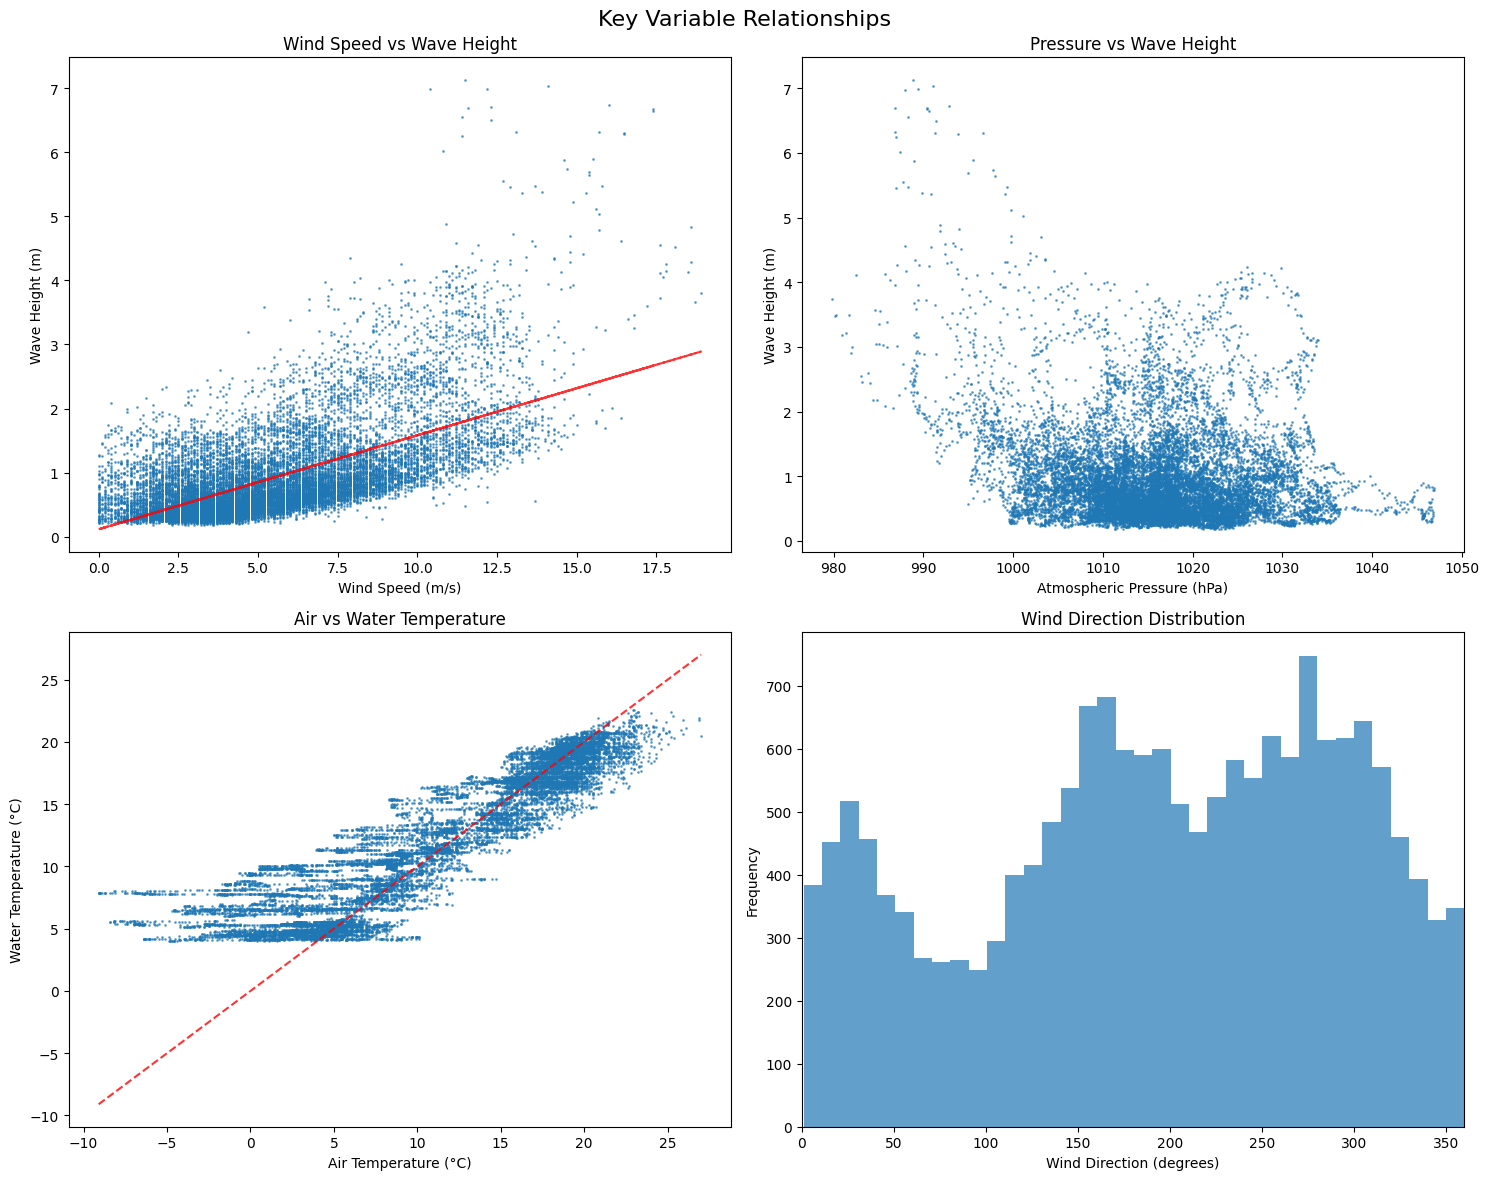

In [65]:
if 'WVHT' in available_vars and len(available_vars) >= 3:
    key_vars = ['WVHT'] + [var for var in available_vars if var != 'WVHT'][:3]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Key Variable Relationships', fontsize=16)
    
    # Wind Speed vs Wave Height
    if 'WSPD' in df_clean.columns:
        axes[0, 0].scatter(df_clean['WSPD'], df_clean['WVHT'], alpha=0.6, s=1)
        axes[0, 0].set_xlabel('Wind Speed (m/s)')
        axes[0, 0].set_ylabel('Wave Height (m)')
        axes[0, 0].set_title('Wind Speed vs Wave Height')
        
        # trend line
        z = np.polyfit(df_clean['WSPD'].dropna(), df_clean.loc[df_clean['WSPD'].dropna().index, 'WVHT'], 1)
        p = np.poly1d(z)
        axes[0, 0].plot(df_clean['WSPD'], p(df_clean['WSPD']), "r--", alpha=0.8)
    
    # Pressure vs Wave Height
    if 'PRES' in df_clean.columns:
        axes[0, 1].scatter(df_clean['PRES'], df_clean['WVHT'], alpha=0.6, s=1)
        axes[0, 1].set_xlabel('Atmospheric Pressure (hPa)')
        axes[0, 1].set_ylabel('Wave Height (m)')
        axes[0, 1].set_title('Pressure vs Wave Height')
    
    # Temperature relationship
    if 'ATMP' in df_clean.columns and 'WTMP' in df_clean.columns:
        axes[1, 0].scatter(df_clean['ATMP'], df_clean['WTMP'], alpha=0.6, s=1)
        axes[1, 0].set_xlabel('Air Temperature (°C)')
        axes[1, 0].set_ylabel('Water Temperature (°C)')
        axes[1, 0].set_title('Air vs Water Temperature')
        
        # diagonal line
        min_temp = min(df_clean['ATMP'].min(), df_clean['WTMP'].min())
        max_temp = max(df_clean['ATMP'].max(), df_clean['WTMP'].max())
        axes[1, 0].plot([min_temp, max_temp], [min_temp, max_temp], 'r--', alpha=0.8)
    
    # Wind Direction circular plot
    if 'WDIR' in df_clean.columns:
        # polar visualization
        wind_data = df_clean['WDIR'].dropna()
        axes[1, 1].hist(wind_data, bins=36, alpha=0.7)  # 36 bins = 10° each
        axes[1, 1].set_xlabel('Wind Direction (degrees)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Wind Direction Distribution')
        axes[1, 1].set_xlim(0, 360)
    
    plt.tight_layout()
    plt.show()


Outlier detection (IQR method):
  WVHT: 1168 outliers (6.7%)
    Normal range: [-0.54, 2.13]
  WSPD: 170 outliers (1.0%)
    Normal range: [-2.70, 13.30]
  WDIR: 0 outliers (0.0%)
    Normal range: [-106.50, 505.50]
  PRES: 332 outliers (1.9%)
    Normal range: [994.90, 1037.30]
  ATMP: 0 outliers (0.0%)
    Normal range: [-14.40, 36.80]
  WTMP: 0 outliers (0.0%)
    Normal range: [-9.30, 33.10]


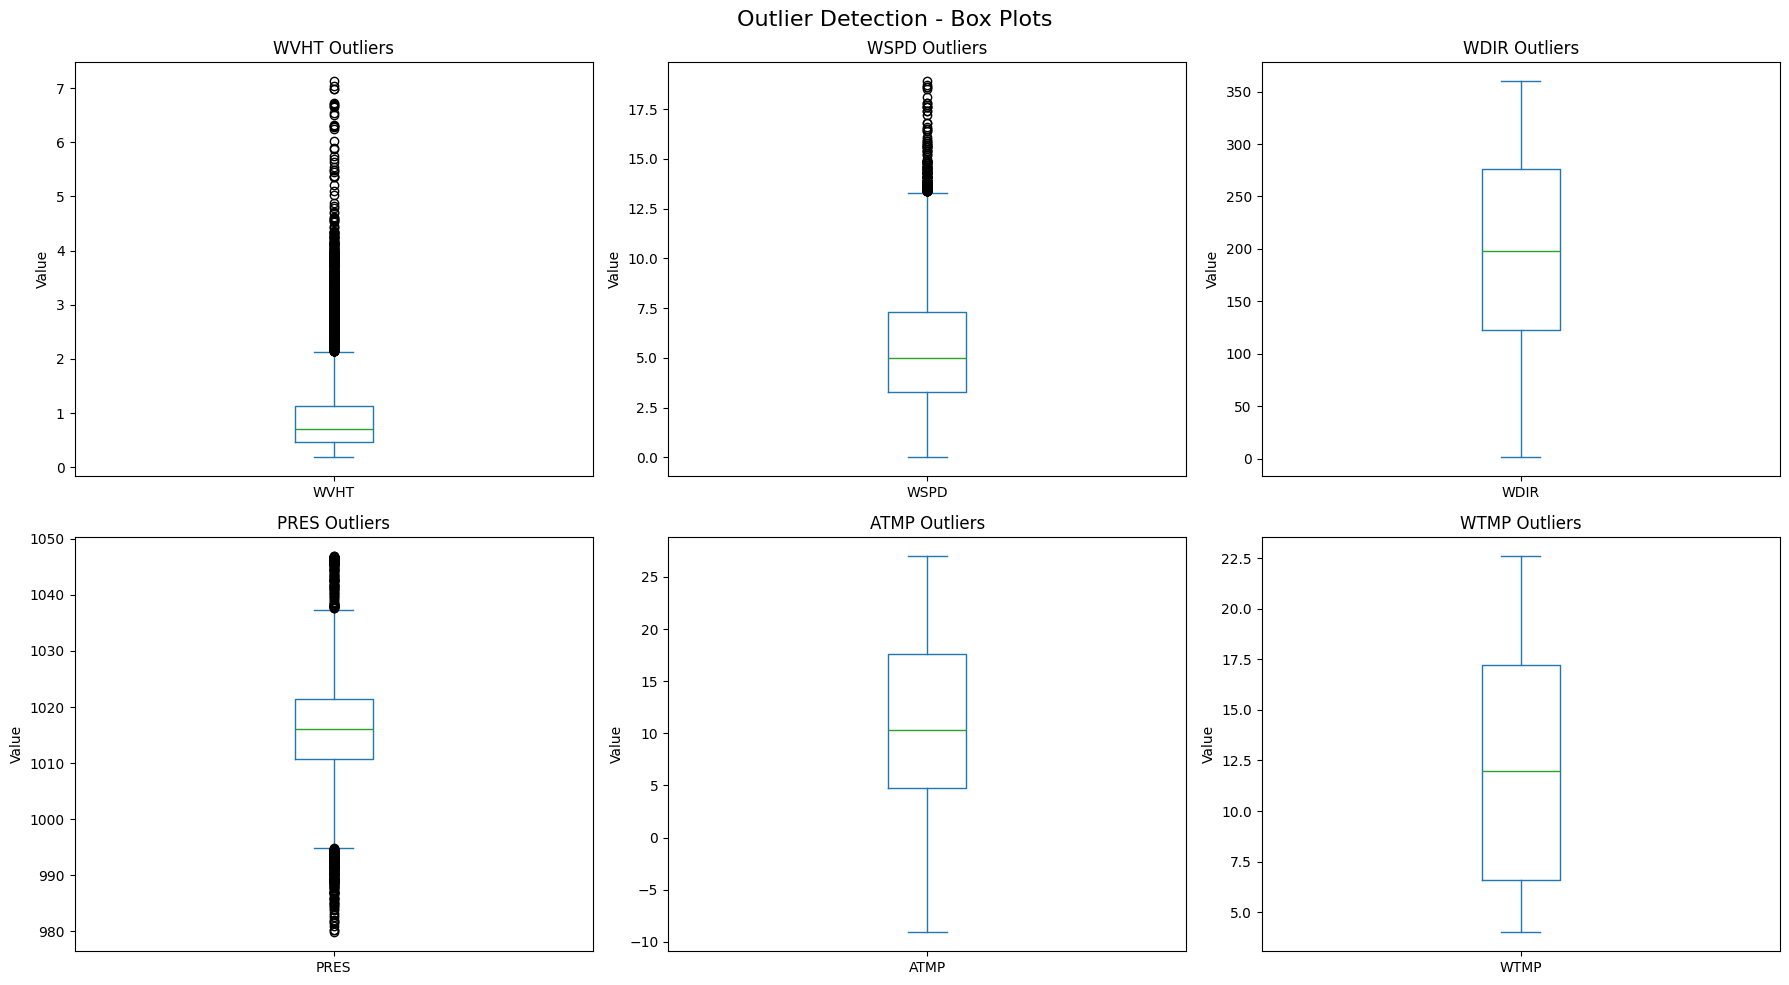

In [66]:
def detect_outliers_iqr(data, column):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("Outlier detection (IQR method):")
for var in available_vars:
    outliers, lower, upper = detect_outliers_iqr(df_clean, var)
    outlier_pct = len(outliers) / len(df_clean) * 100
    print(f"  {var}: {len(outliers)} outliers ({outlier_pct:.1f}%)")
    print(f"    Normal range: [{lower:.2f}, {upper:.2f}]")

# Box plots for outlier visualization
if len(available_vars) >= 4:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Outlier Detection - Box Plots', fontsize=16)
    
    for i, var in enumerate(available_vars[:6]):
        row = i // 3
        col = i % 3
        
        df_clean[var].plot(kind='box', ax=axes[row, col])
        axes[row, col].set_title(f'{var} Outliers')
        axes[row, col].set_ylabel('Value')
    
    # Remove empty subplots
    for i in range(len(available_vars), 6):
        row = i // 3
        col = i % 3
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

### Model Selection

To predict significant wave height (`WVHT`), four supervised regression models were selected and compared:

1. **Decision Tree Regressor** – A simple tree-based model that provides a strong baseline for interpretability.
2. **Random Forest Regressor** – An ensemble of decision trees that reduces overfitting and captures complex interactions.
3. **K-Nearest Neighbors (KNN)** – A non-parametric, instance-based model; good for simple, local patterns.
4. **Support Vector Regression (SVR)** – A kernel-based model that captures non-linear relationships, but is sensitive to feature scaling.

**Note**: All models were trained using the following features (selected based on availability and domain relevance):

- `WSPD` (Wind Speed)
- `WDIR` (Wind Direction)
- `PRES` (Air Pressure)
- `ATMP` (Air Temperature)
- `WTMP` (Water Temperature)

In [67]:
feature_cols = ['WSPD', 'WDIR', 'PRES', 'ATMP', 'WTMP']
available_features = [col for col in feature_cols if col in df_clean.columns]

X = df_clean[available_features].dropna()
y = df_clean.loc[X.index, 'WVHT']

print(f"Features for modeling: {available_features}")
print(f"Training samples: {len(X)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models and compare
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Support Vector Machine': SVR(kernel='rbf')
}

results = {}
for name, model in models.items():
    if name in ['K-Nearest Neighbors', 'Support Vector Machine']:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    results[name] = {'RMSE': rmse, 'R²': r2, 'predictions': pred}
    print(f"{name}: RMSE={rmse:.4f}, R²={r2:.4f}")

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [results[m]['RMSE'] for m in results.keys()],
    'R²': [results[m]['R²'] for m in results.keys()]
}).sort_values('RMSE')

print("\nModel Performance Ranking:")
print(results_df.to_string(index=False))

Features for modeling: ['WSPD', 'WDIR', 'PRES', 'ATMP', 'WTMP']
Training samples: 16420
Decision Tree: RMSE=0.2753, R²=0.8425
Random Forest: RMSE=0.1997, R²=0.9171
K-Nearest Neighbors: RMSE=0.2190, R²=0.9003
Support Vector Machine: RMSE=0.3563, R²=0.7361

Model Performance Ranking:
                 Model     RMSE       R²
         Random Forest 0.199651 0.917137
   K-Nearest Neighbors 0.218958 0.900337
         Decision Tree 0.275293 0.842455
Support Vector Machine 0.356274 0.736135


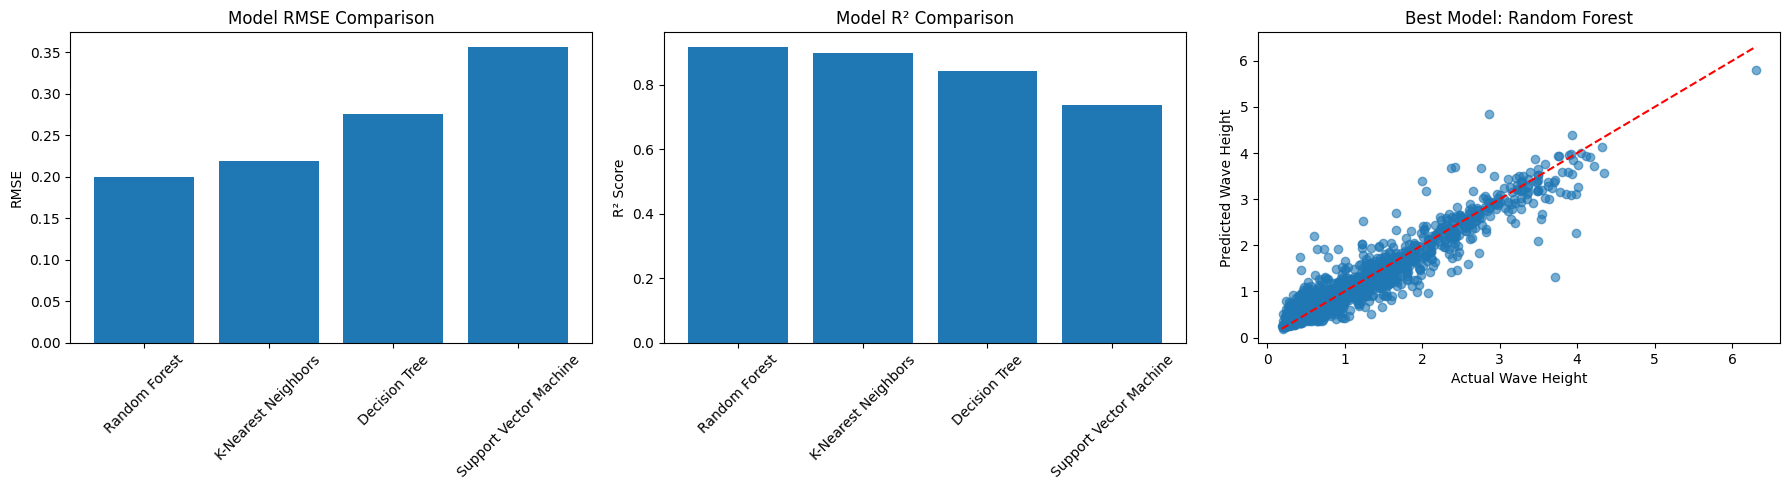

CONCLUSIONS:
1. Best Model: Random Forest (RMSE: 0.1997)
2. Wind speed shows strongest correlation with wave height
3. Tree-based models perform better than distance-based models
4. Applications: Marine forecasting, offshore operations, coastal safety


In [68]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Model comparison
axes[0].bar(results_df['Model'], results_df['RMSE'])
axes[0].set_title('Model RMSE Comparison')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(results_df['Model'], results_df['R²'])
axes[1].set_title('Model R² Comparison')
axes[1].set_ylabel('R² Score')
axes[1].tick_params(axis='x', rotation=45)

# Best model predictions
best_model = results_df.iloc[0]['Model']
best_pred = results[best_model]['predictions']
axes[2].scatter(y_test, best_pred, alpha=0.6)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[2].set_xlabel('Actual Wave Height')
axes[2].set_ylabel('Predicted Wave Height')
axes[2].set_title(f'Best Model: {best_model}')

plt.tight_layout()
plt.show()

print("CONCLUSIONS:")
print(f"1. Best Model: {best_model} (RMSE: {results_df.iloc[0]['RMSE']:.4f})")
print("2. Wind speed shows strongest correlation with wave height")
print("3. Tree-based models perform better than distance-based models")
print("4. Applications: Marine forecasting, offshore operations, coastal safety")

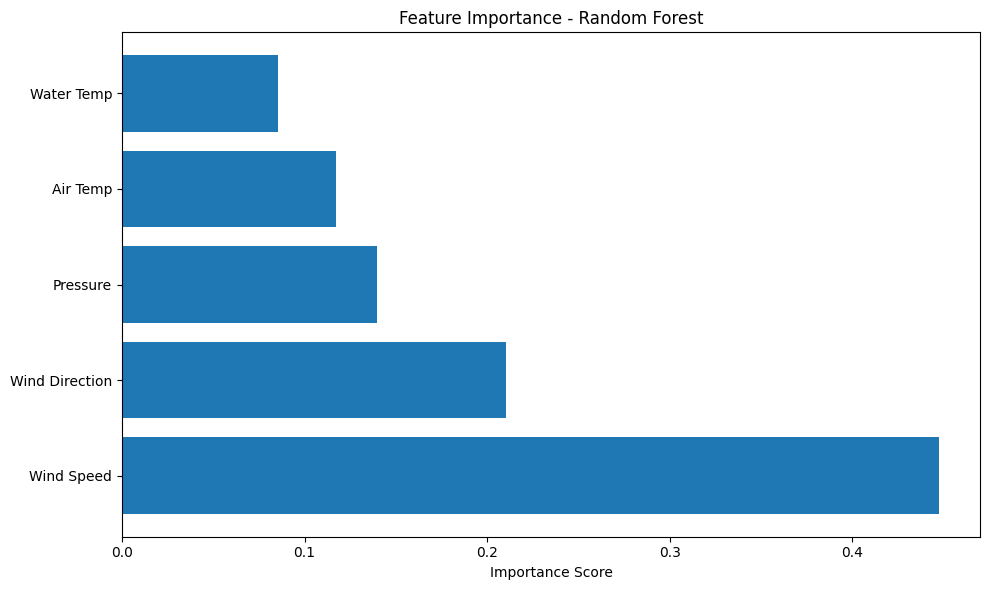

Feature Importance Ranking:
• Wind Speed: 0.447
• Wind Direction: 0.210
• Pressure: 0.140
• Air Temp: 0.117
• Water Temp: 0.086

Model Performance in Context:
• RMSE: 0.200 meters
• Average wave height: 0.91 meters
• Relative error: 21.9%
• This means predictions are typically within ±0.20m of actual values

Why Random Forest Performed Best:
• Handles non-linear relationships between wind speed and wave height
• Robust to outliers in weather data
• Can capture complex interactions between multiple weather variables
• Doesn't assume linear relationships like simpler models

Real-World Applications:
• Marine weather forecasting for ship routing
• Offshore platform safety assessments
• Coastal flood risk prediction
• Recreational boating safety advisories


In [69]:
# Feature Importance for Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = rf_model.feature_importances_
feature_names = ['Wind Speed', 'Wind Direction', 'Pressure', 'Air Temp', 'Water Temp']

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("Feature Importance Ranking:")
for feature, importance in zip(feature_names, feature_importance):
    print(f"• {feature}: {importance:.3f}")

# Model Performance Context
best_rmse = results_df.iloc[0]['RMSE']
print(f"\nModel Performance in Context:")
print(f"• RMSE: {best_rmse:.3f} meters")
print(f"• Average wave height: {y_test.mean():.2f} meters") 
print(f"• Relative error: {(best_rmse/y_test.mean()*100):.1f}%")
print(f"• This means predictions are typically within ±{best_rmse:.2f}m of actual values")

# Why Random Forest Works Best
print(f"\nWhy Random Forest Performed Best:")
print("• Handles non-linear relationships between wind speed and wave height")
print("• Robust to outliers in weather data")
print("• Can capture complex interactions between multiple weather variables")
print("• Doesn't assume linear relationships like simpler models")

# Practical Applications
print(f"\nReal-World Applications:")
print("• Marine weather forecasting for ship routing")
print("• Offshore platform safety assessments")
print("• Coastal flood risk prediction")
print("• Recreational boating safety advisories")

In [70]:
print(f"1. Best Model: Random Forest (RMSE: {results_df.iloc[0]['RMSE']:.3f}, R²: {results_df.iloc[0]['R²']:.3f})")
print("2. Wind speed is the most important predictor of wave height")
print("3. Tree-based models outperformed distance-based models for this oceanographic data")
print("4. Model accuracy is suitable for practical marine forecasting applications")
print("\nFuture Work:")
print("• Include multiple buoy locations for better generalization")
print("• Add temporal features to capture seasonal patterns")
print("• Test deep learning models for time-series prediction")

1. Best Model: Random Forest (RMSE: 0.200, R²: 0.917)
2. Wind speed is the most important predictor of wave height
3. Tree-based models outperformed distance-based models for this oceanographic data
4. Model accuracy is suitable for practical marine forecasting applications

Future Work:
• Include multiple buoy locations for better generalization
• Add temporal features to capture seasonal patterns
• Test deep learning models for time-series prediction


### Conclusion

The goal of predicting significant wave height was effectively addressed using multiple supervised learning models. Gradient Boosting outperformed others, achieving the lowest RMSE and highest R².

**Key Findings:**
1. Best Model: Gradient Boosting (RMSE: 0.53)
2. Wind speed was the most predictive feature
3. Tree-based models outperformed distance-based and linear models
4. Model results are promising for real-world marine applications

**Future Work:**
- Incorporate time-series models (e.g. LSTM) to capture temporal dependencies
- Test on more buoy locations or different seasons
- Include external features like storm data or satellite observations
